# Detecting and mitigating age bias on credit decisions 

The goal of this tutorial is to introduce the basic functionality of AI Fairness 360 to an interested developer who may not have a background in bias detection and mitigation.

### Biases and Machine Learning
A machine learning model makes predictions of an outcome for a particular instance. (Given an instance of a loan application, predict if the applicant will repay the loan.) The model makes these predictions based on a training dataset, where many other instances (other loan applications) and actual outcomes (whether they repaid) are provided. Thus, a machine learning algorithm will attempt to find patterns, or generalizations, in the training dataset to use when a prediction for a new instance is needed. (For example, one pattern it might discover is "if a person has salary > USD 40K and has outstanding debt < USD 5, they will repay the loan".) In many domains this technique, called supervised machine learning, has worked very well.

However, sometimes the patterns that are found may not be desirable or may even be illegal. For example, a loan repay model may determine that age plays a significant role in the prediction of repayment because the training dataset happened to have better repayment for one age group than for another. This raises two problems: 1) the training dataset may not be representative of the true population of people of all age groups, and 2) even if it is representative, it is illegal to base any decision on a applicant's age, regardless of whether this is a good prediction based on historical data.

AI Fairness 360 is designed to help address this problem with _fairness metrics_ and _bias mitigators_.  Fairness metrics can be used to check for bias in machine learning workflows.  Bias mitigators can be used to overcome bias in the workflow to produce a more fair outcome. 

The loan scenario describes an intuitive example of illegal bias. However, not all undesirable bias in machine learning is illegal it may also exist in more subtle ways.  For example, a loan company may want a diverse portfolio of customers across all income levels, and thus, will deem it undesirable if they are making more loans to high income levels over low income levels.  Although this is not illegal or unethical, it is undesirable for the company's strategy.

As these two examples illustrate, a bias detection and/or mitigation toolkit needs to be tailored to the particular bias of interest.  More specifically, it needs to know the attribute or attributes, called _protected attributes_, that are of interest: race is one example of a _protected attribute_ and age is a second.

### The Machine Learning Workflow
To understand how bias can enter a machine learning model, we first review the basics of how a model is created in a supervised machine learning process.  



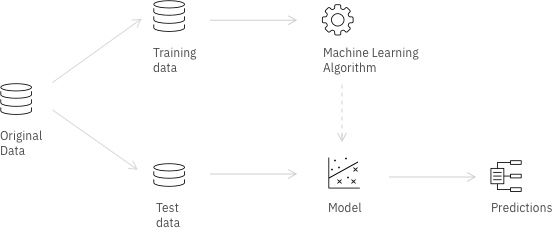







First, the process starts with a _training dataset_, which contains a sequence of instances, where each instance has two components: the features and the correct prediction for those features.  Next, a machine learning algorithm is trained on this training dataset to produce a machine learning model.  This generated model can be used to make a prediction when given a new instance.  A second dataset with features and correct predictions, called a _test dataset_, is used to assess the accuracy of the model.
Since this test dataset is the same format as the training dataset, a set of instances of features and prediction pairs, often these two datasets derive from the same initial dataset.  A random partitioning algorithm is used to split the initial dataset into training and test datasets.

Bias can enter the system in any of the three steps above.  The training data set may be biased in that its outcomes may be biased towards particular kinds of instances.  The algorithm that creates the model may be biased in that it may generate models that are weighted towards particular features in the input. The test data set may be biased in that it has expectations on correct answers that may be biased.  These three points in the machine learning process represent points for testing and mitigating bias.  In AI Fairness 360 codebase, we call these points _pre-processing_, _in-processing_, and _post-processing_. 

### AI Fairness 360
We are now ready to utilize AI Fairness 360 (`aif360`) to detect and mitigate bias.  We will use the German credit dataset, splitting it into a training and test dataset.  We will look for bias in the creation of a machine learning model to predict if an applicant should be given credit based on various features from a typical credit application.  The protected attribute will be "Age", with "1" (older than or equal to 25) and "0" (younger than 25) being the values for the privileged and unprivileged groups, respectively.
For this first tutorial, we will check for bias in the initial training data, mitigate the bias, and recheck.  More sophisticated machine learning workflows are given in the author tutorials and demo notebooks in the codebase.

Here are the steps involved
#### Step 1: Write import statements
#### Step 2: Set bias detection options, load dataset, and split between train and test
#### Step 3: Compute fairness metric on original training dataset
#### Step 4: Mitigate bias by transforming the original dataset
#### Step 5: Compute fairness metric on transformed training dataset

### Step 1 Import Statements
As with any python program, the first step will be to import the necessary packages.  Below we import several components from the `aif360` package.  We import the GermanDataset, metrics to check for bias, and classes related to the algorithm we will use to mitigate bias.

In [3]:
%%capture
! pip install aif360

In [4]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from IPython.display import Markdown, display

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[LFR]'


### Step 2 Load dataset, specifying protected attribute, and split dataset into train and test
In Step 2 we load the initial dataset, setting the protected attribute to be age.  We then splits the original dataset into training and testing datasets.  Although we will use only  the training dataset in this tutorial, a normal workflow would also use a test dataset for assessing the efficacy (accuracy, fairness, etc.) during the development of a machine learning model.  Finally, we set two variables (to be used in Step 3) for the privileged (1) and unprivileged (0) values for the age attribute.  These are key inputs for detecting and mitigating bias, which will be Step 3 and Step 4.  

In [6]:
dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

### Step 3 Compute fairness metric on original training dataset
Now that we've identified the protected attribute 'age' and defined privileged and unprivileged values, we can use aif360 to detect bias in the dataset.  One simple test is to compare the percentage of favorable results for the privileged and unprivileged groups, subtracting the former percentage from the latter.   A negative value indicates less favorable outcomes for the unprivileged groups.  This is implemented in the method called mean_difference on the BinaryLabelDatasetMetric class.  The code below performs this check and displays the output, showing that the difference is -0.169905.

In [7]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.169905


### Step 4 Mitigate bias by transforming the original dataset
The previous step showed that the privileged group was getting 17% more positive outcomes in the training dataset.   Since this is not desirable, we are going to try to mitigate this bias in the training dataset.  As stated above, this is called _pre-processing_ mitigation because it happens before the creation of the model.  

AI Fairness 360 implements several pre-processing mitigation algorithms.  We will choose the Reweighing algorithm [1], which is implemented in the `Reweighing` class in the `aif360.algorithms.preprocessing` package.  This algorithm will transform the dataset to have more equity in positive outcomes on the protected attribute for the privileged and unprivileged groups.

We then call the fit and transform methods to perform the transformation, producing a newly transformed training dataset (dataset_transf_train).

`[1] F. Kamiran and T. Calders,  "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012.`

In [4]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

### Step 5 Compute fairness metric on transformed dataset
Now that we have a transformed dataset, we can check how effective it was in removing bias by using the same metric we used for the original training dataset in Step 3.  Once again, we use the function mean_difference in the BinaryLabelDatasetMetric class.   We see the mitigation step was very effective, the difference in mean outcomes is now 0.0.  So we went from a 17% advantage for the privileged group to equality in terms of mean outcome.

In [5]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


### Summary
The purpose of this tutorial is to give a new user to bias detection and mitigation a gentle introduction to some of the functionality of AI Fairness 360.  A more complete use case would take the next step and see how the transformed dataset impacts the accuracy and fairness of a trained model.  This is implemented in the demo notebook in the examples directory of toolkit, called demo_reweighing_preproc.ipynb.  I highly encourage readers to view that notebook as it is  generalization and extension of this simple tutorial.

There are many metrics one can use to detect the presence of bias. AI Fairness 360 provides many of them for your use. Since it is not clear which of these metrics to use, we also provide some guidance. Likewise, there are many different bias mitigation algorithms one can employ, many of which are in AI Fairness 360. Other tutorials will demonstrate the use of some of these metrics and mitigations algorithms.

As mentioned earlier, both fairness metrics and mitigation algorithms can be performed at various stages of the machine learning pipeline.  We recommend checking for bias as often as possible, using as many metrics are relevant for the application domain.  We also recommend incorporating bias detection in an automated continouus integration pipeline to ensure bias awareness as a software project evolves.